# Defect Prediction on production lines by VALEO
## Challenge context
Valeo is a French global automotive supplier headquartered in France, listed on the Paris Stock Exchange (CAC-40 Index). It supplies a wide range of products to automakers and the aftermarket. The Group employs 113,600 people in 33 countries worldwide. It has 186 production plants, 59 R&D centers and 15 distribution platforms. Its strategy is focused on innovation and development in high-growth potential regions and emerging countries. Valeo ranked as France's leading patent filer from 2016 to 2018.
 
## Challenge goals
The goal of the challenge is to predict defect on starter motor production lines. During production samples assembly, different values (torques, angles ...) are measured on different mounting stations. At the end of the line, additional measures are performed on two test benches in order to isolate defects. As a result, samples are tagged ‘OK’, ‘KO’. We would like to design a model that could identify such defects before the test bench step.

## Data description
**ID** = PROC_TRACEINFO = it’s a unique code given to the product. <br>
Example : I-B-XA1207672-190701-00494.<br>
XA1207672 is the **reference**.<br>
190701 is the **date**: here 01st of July of year 2019.<br>
00494 is the **unique code** given to the product, whatever it happens, the product will have this id number frozen forever. This number is increased by 1 each time we process a new product, every 12s. So for example : I-B-XA1207672-190701-00495 is the next product.<br>

**Inputs** : Input features are measures collected on different assembly stations with the sensors or devices connected to Programmable Logic Controllers which are storing all of them to keep the full quality traceability. (Examples : OP070_V_1_angle_value, OP120_Rodage_I_value, etc…).

**Output** : This is the result value of OP130 (test bench). Value 0 is assigned to **OK** samples (passed) and value 1 is assigned to **KO** samples (failed). This is the combined result of multiple electrical, acoustic and vibro-acoustic tests.

**The target** is to find the best prediction : Output = f (inputs). The dataset contains 34515 training samples and 8001 test samples.


***

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import norm
import os

In [2]:
nb_path = os.path.abspath(".")
InteractiveShell.ast_node_interactivity = "all"
sns.set(color_codes=True)

# 1. Exploratory Data Analysis
# Summary

## Variable Identification and Basic Analysis
- **Target Variable** : Binar OP130_Resultat_Global_v
- **Dataset Size** : train : 34515 rows × 15 columns, test : 8001 rows × 14 columns
- **Data Types** : float64 :    13, int64 :       1, object :      1
- **Missing Values** : OP100_Capuchon_insertion_mesure is missing 53,9%
- **Variable signification**: 
    - Machine OP070_V1 is associated with Twisting Operation
    - Machine OP070_V2 is associated with Twisting Operation
    - Machine OP090 is associated with SnapRing related Operation
    - Machine OP100 is associated with Capuchon Insertion
    - Machine OP110 is associated with Vissage
    - Machine OP120 is associated with Rodage
    
## Univariate Analysis
- **Visualisation of the Target** : imbalanced data as 99.1% is labeled "OK" (or 0) and 0.9% is labeled "KO" (or 1).
    
    
- **Visualisation of Variables** : 
    * not all normally distributed , not standardized, some variables heavily skewed.
    * We can see that most variables are discrete, this seems to be due to the digital nature of the measures
   

## Bivariate Analysis

- **Variables / Target Relation** : 
    - Histogram: no apparent difference in distribution betweeen "KO" and "OK" labeled variables. There are also no outliers in any of the "KO" labeled varaibles.
    - Boxplot: smaller variance in OP100_Capuchon_insertion_mesure, lower median value for OP070_V_2_torque_value, OP070_V_1_torque_value.
   

- **Variables / Variables Relation** : variables from the same machine tend have a higher correlation degree.
   

## Hypothesis Testing : T-test
- Samples which failed the test bench has a significantly different values of:<br>
OP070_V_1_angle_value <br>
OP070_V_2_torque_value<br>
OP070_V_1_torque_value<br>
OP090_SnapRingFinalStroke_value<br>
OP090_SnapRingPeakForce_value<br>
OP090_SnapRingMidPointForce_val<br>
OP100_Capuchon_insertion_mesure 

H0 = "KO" and "OK" samples have equal mean values  <br>

alpha = 0.02

## (idea bucket list)
- engineer PROC_TRACEINFO to datetime column
- plot variables in the chronological order
    

***

## Variable Identification and Basic Analysis

In [3]:
testset = pd.read_csv(os.path.join(nb_path,"testinputs.csv"))
trainset = pd.read_csv(os.path.join(nb_path,"traininginputs.csv")).merge(pd.read_csv(os.path.join(nb_path,"trainingoutput.csv")), on="PROC_TRACEINFO")

In [4]:
target = "Binar OP130_Resultat_Global_v"
code = 'PROC_TRACEINFO'
measures = ['OP070_V_1_angle_value',
       'OP090_SnapRingPeakForce_value', 'OP070_V_2_angle_value',
       'OP120_Rodage_I_mesure_value', 'OP090_SnapRingFinalStroke_value',
       'OP110_Vissage_M8_torque_value', 'OP100_Capuchon_insertion_mesure',
       'OP120_Rodage_U_mesure_value', 'OP070_V_1_torque_value',
       'OP090_StartLinePeakForce_value', 'OP110_Vissage_M8_angle_value',
       'OP090_SnapRingMidPointForce_val', 'OP070_V_2_torque_value']

In [14]:
ko_index = trainset[trainset[target]==1].index

In [5]:
trainset.describe()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar OP130_Resultat_Global_v
count,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,15888.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000
mean,159.906922,156.915055,159.618236,113.350222,11.970190,12.256785,0.388173,11.971027,6.548403,23.630152,17.878398,97.700978,6.550867,0.008837
std,15.662650,11.271492,15.091490,3.528522,0.169873,0.065319,0.024425,0.003050,0.097602,2.546341,6.785079,6.837714,0.094814,0.093589
min,101.800000,0.000000,82.000000,99.990000,0.000000,12.030000,0.240000,11.970000,5.670000,0.000000,6.300000,0.000000,5.740000,0.000000
25%,148.700000,149.210000,149.400000,111.040000,11.850000,12.210000,0.380000,11.970000,6.410000,22.280000,13.500000,94.310000,6.420000,0.000000
50%,158.000000,156.180000,158.700000,113.160000,12.040000,12.260000,0.390000,11.970000,6.610000,23.880000,16.400000,98.500000,6.610000,0.000000
75%,169.300000,164.380000,168.900000,115.380000,12.080000,12.300000,0.410000,11.970000,6.620000,25.290000,20.200000,102.230000,6.610000,0.000000
max,198.300000,196.920000,198.100000,177.950000,12.190000,12.500000,0.420000,11.990000,6.670000,43.410000,84.600000,127.300000,6.670000,1.000000


In [6]:
trainset.shape

(34515, 15)

In [7]:
testset.shape

(8001, 14)

In [8]:
trainset.dtypes.value_counts()

float64    13
object      1
int64       1
dtype: int64

<AxesSubplot:>

<AxesSubplot:>

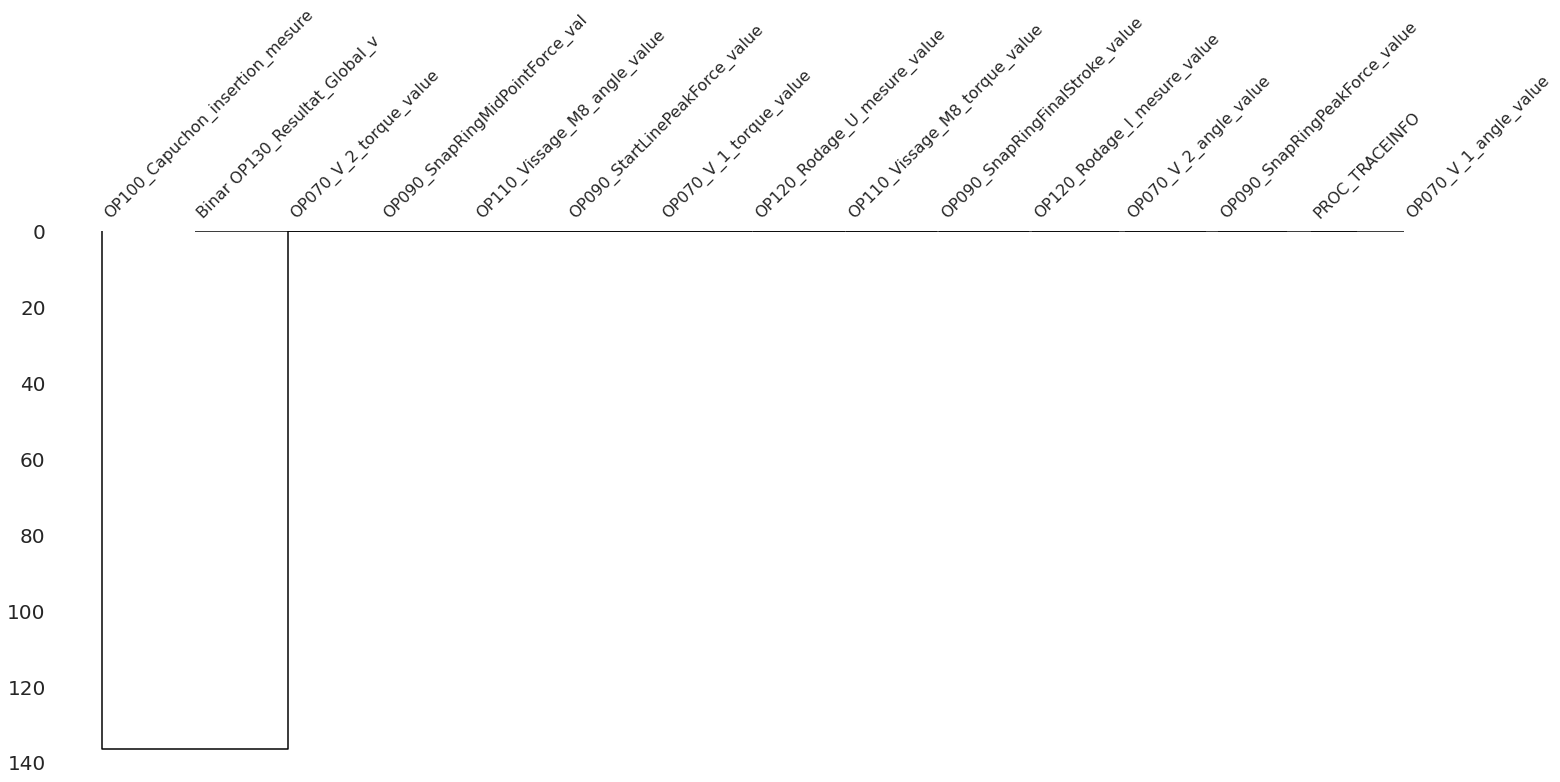

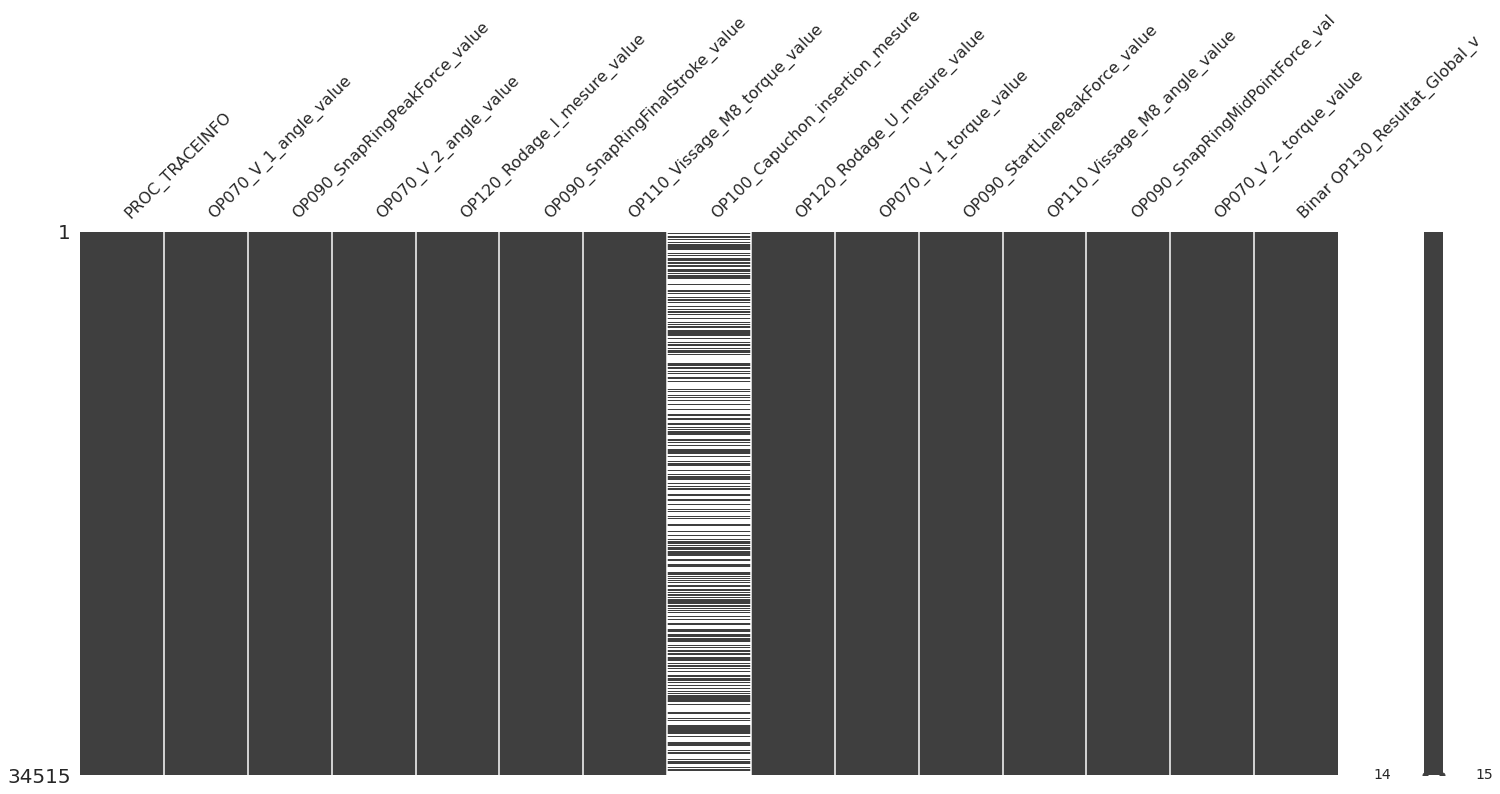

In [9]:
msno.dendrogram(trainset)
msno.matrix(trainset)

In [10]:
trainset['OP100_Capuchon_insertion_mesure'].isna().value_counts(normalize=True)

True     0.539678
False    0.460322
Name: OP100_Capuchon_insertion_mesure, dtype: float64

## Univariate Analysis

### Visualisation of the Target

In [21]:
trainset["Binar OP130_Resultat_Global_v"].value_counts(normalize=True)

0    0.991163
1    0.008837
Name: Binar OP130_Resultat_Global_v, dtype: float64

### Visualisation of Variables

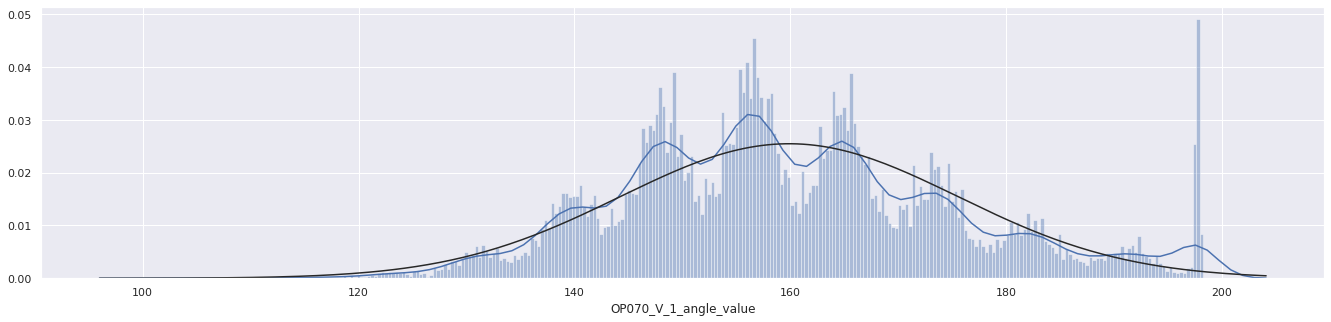

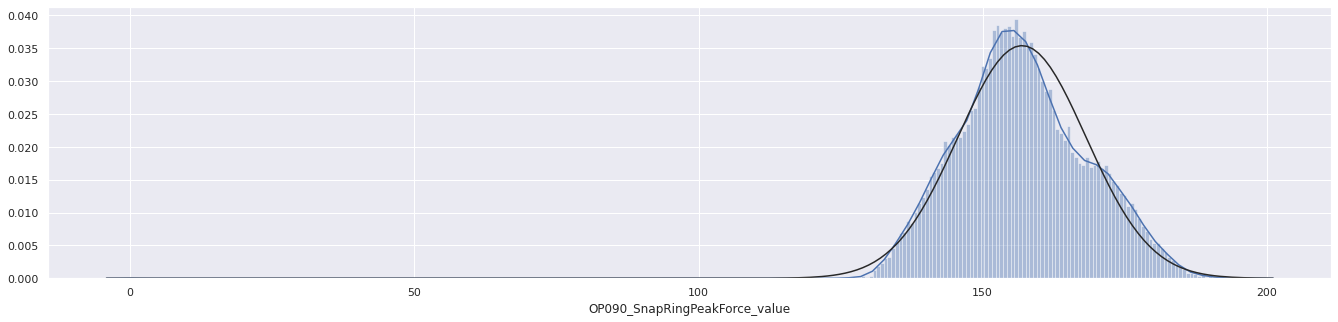

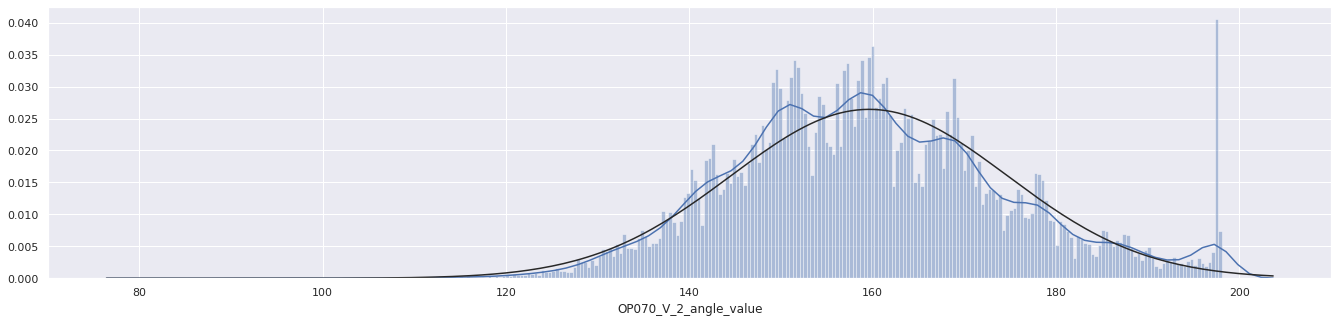

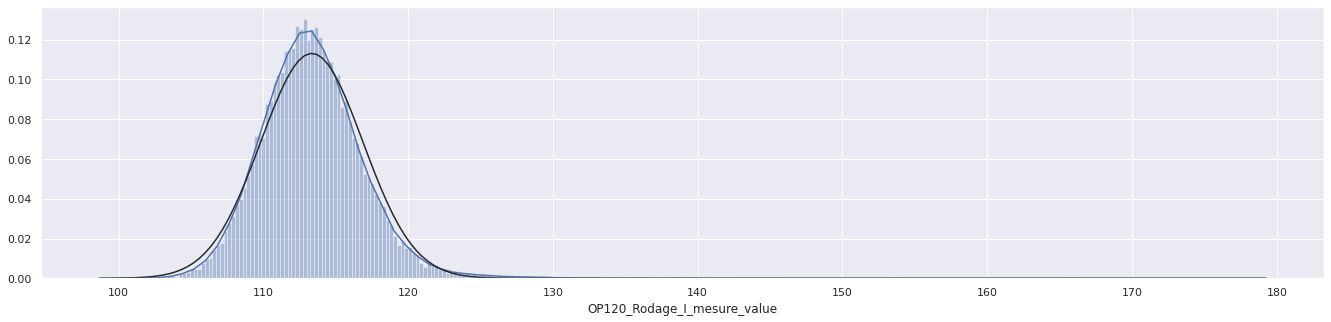

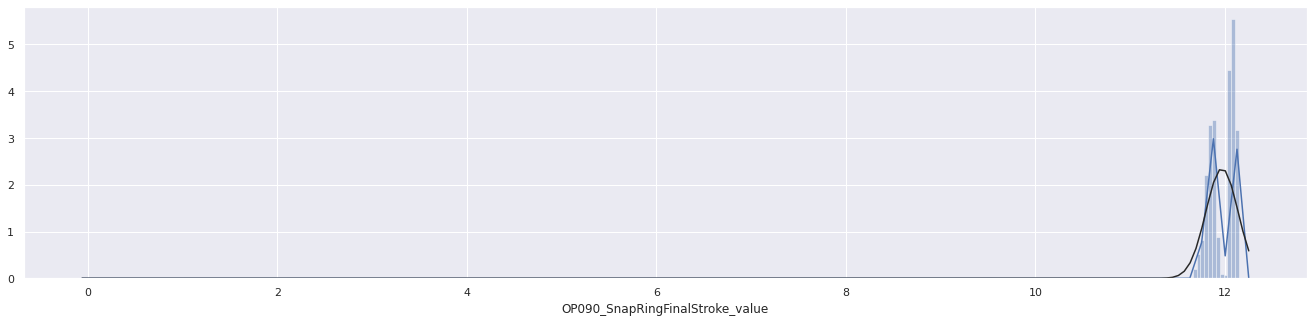

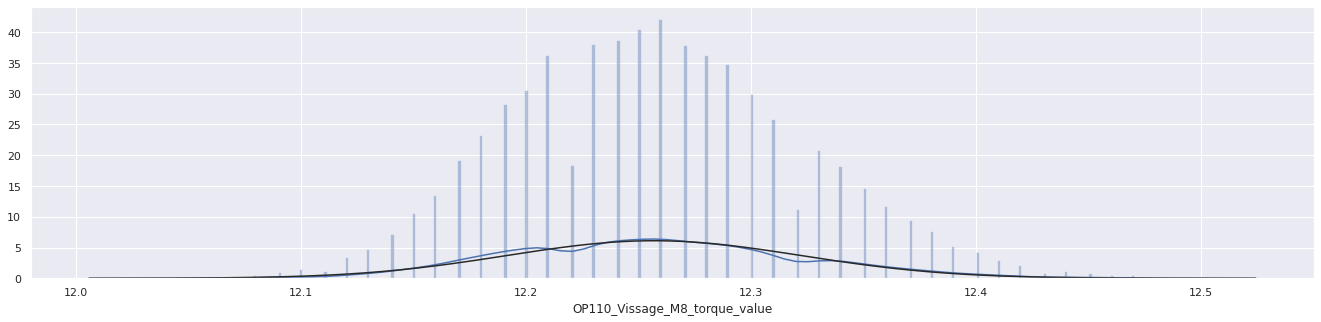

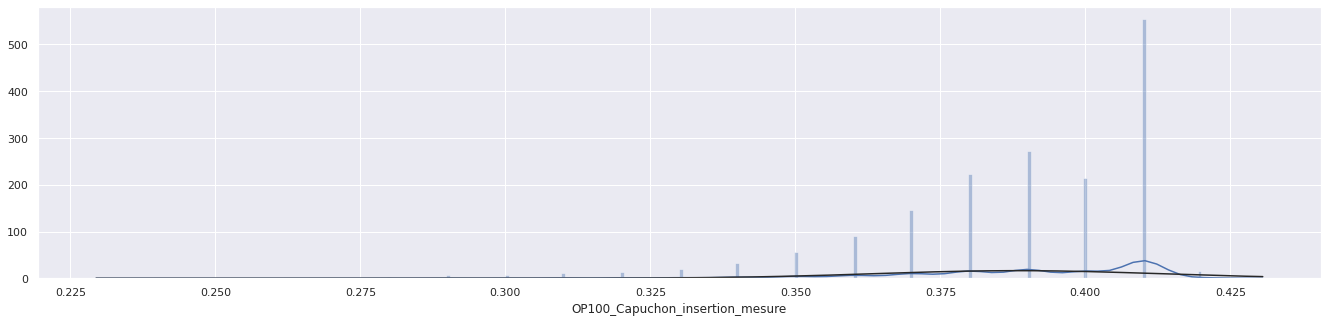

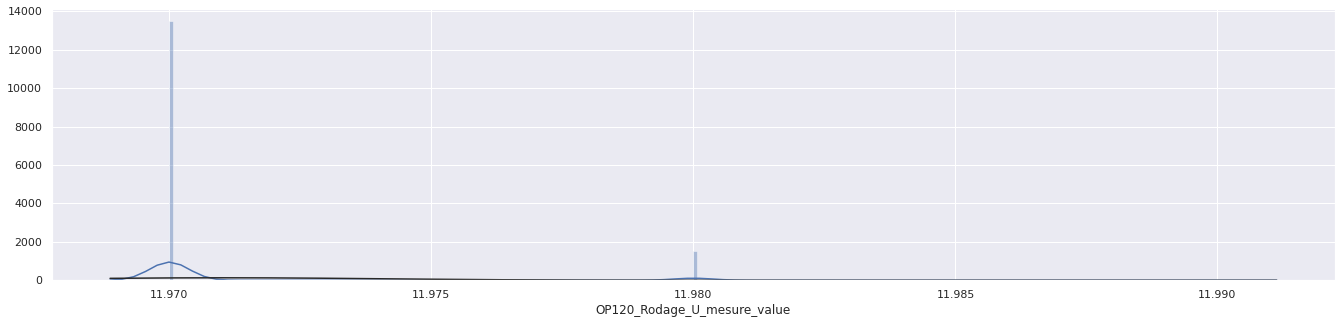

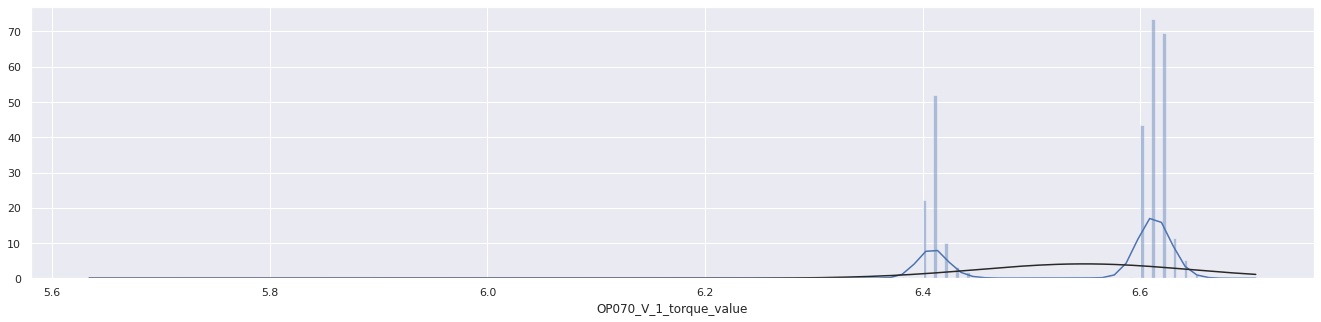

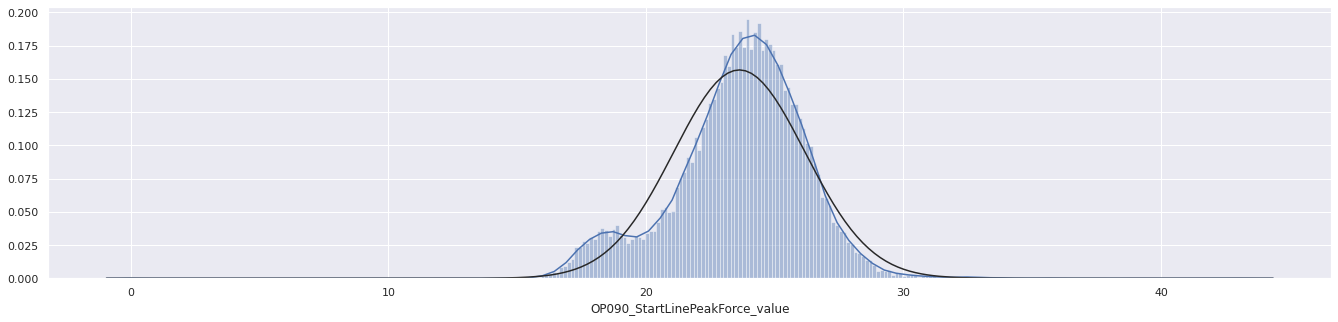

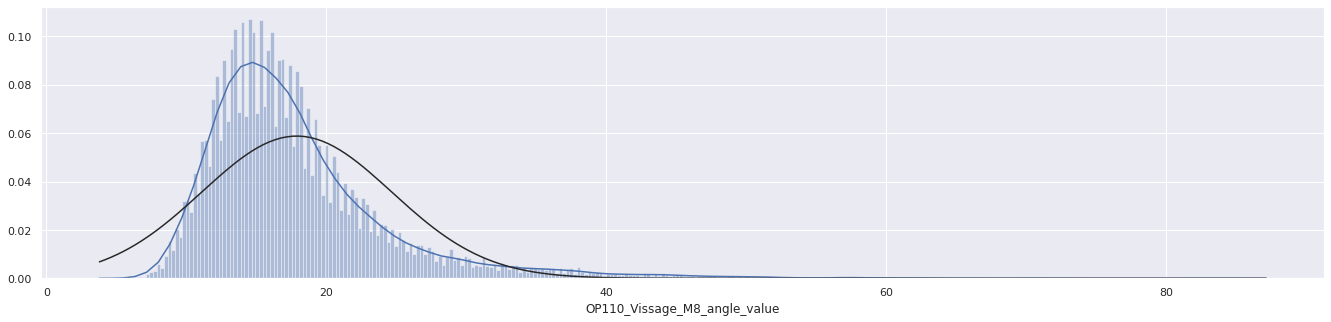

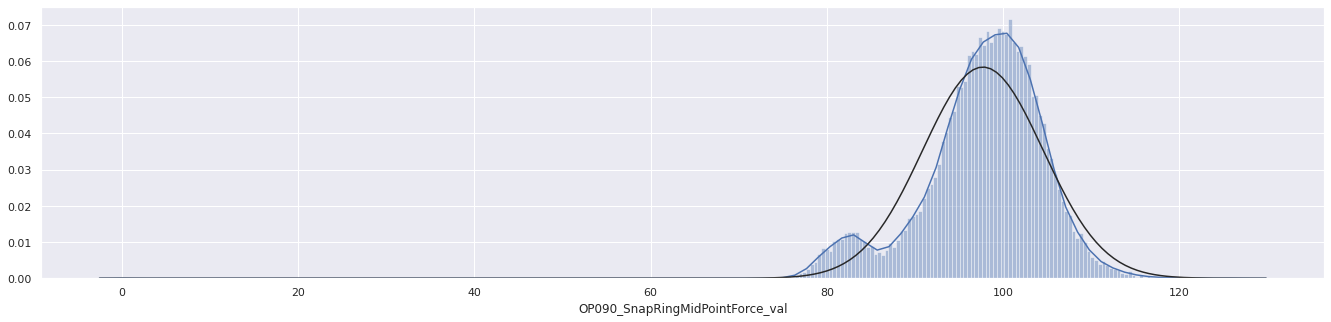

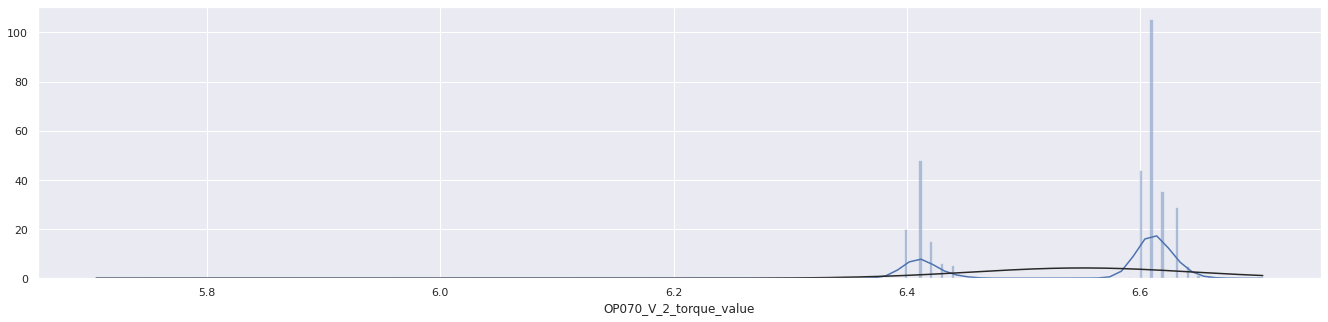

In [6]:
for col in trainset.select_dtypes("float"):
    _ = plt.figure(figsize=(23,5));
    _ = sns.distplot(trainset[col],fit=norm, bins= 300);

In [16]:
#number of distinct values per variable
trainset.nunique().sort_values()

Binar OP130_Resultat_Global_v          2
OP120_Rodage_U_mesure_value            3
OP100_Capuchon_insertion_mesure       19
OP110_Vissage_M8_torque_value         48
OP090_SnapRingFinalStroke_value       56
OP070_V_2_torque_value                64
OP070_V_1_torque_value                70
OP110_Vissage_M8_angle_value         522
OP070_V_1_angle_value                831
OP070_V_2_angle_value                840
OP090_StartLinePeakForce_value      1515
OP120_Rodage_I_mesure_value         2100
OP090_SnapRingMidPointForce_val     3580
OP090_SnapRingPeakForce_value       5194
PROC_TRACEINFO                     34515
dtype: int64

## Bivariate Analysis

### Variables / Target Relation: Histogram

Wrong Correlations: Although we don't know what the features stand for, it will be useful to understand how each of this features influence the result (KO or OK), by having an imbalance dataframe we are not able to see the true correlations between the class and features.

In [30]:
#We create a dataframe with a 50/50 ratio of "KO" and "KO" labeled data.
ok_trainset = trainset[trainset[target]==0]
ko_trainset = trainset[trainset[target]==1]

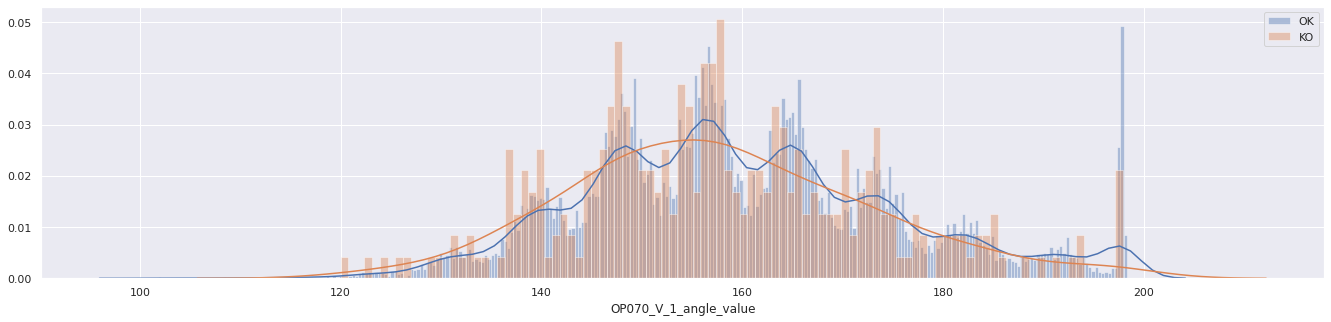

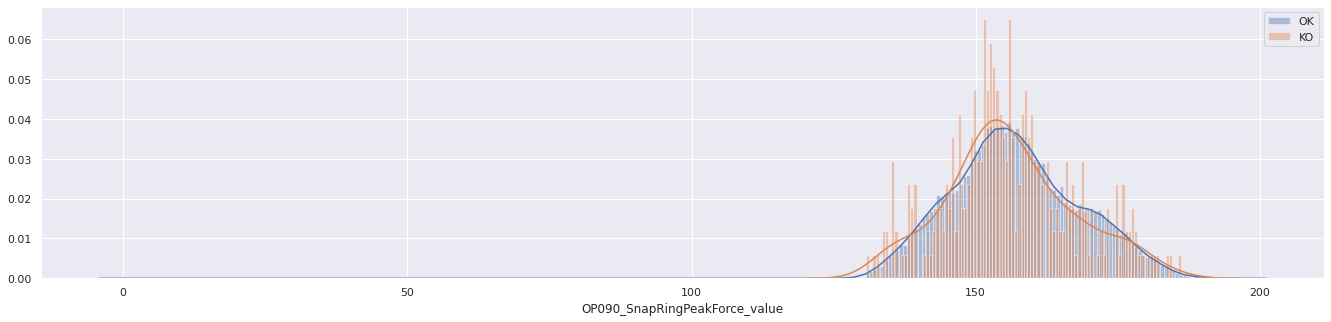

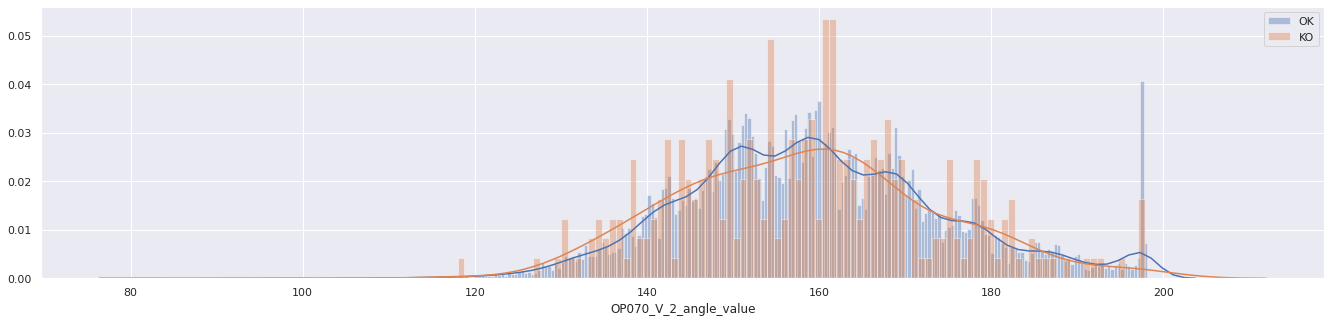

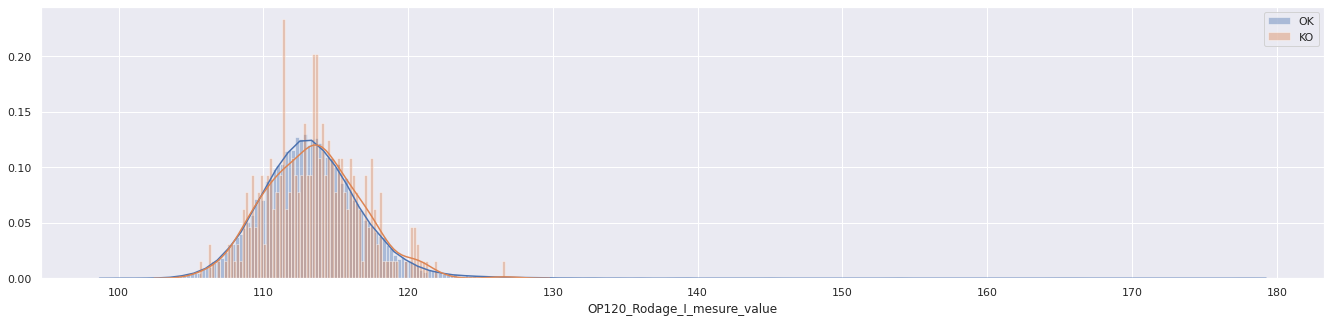

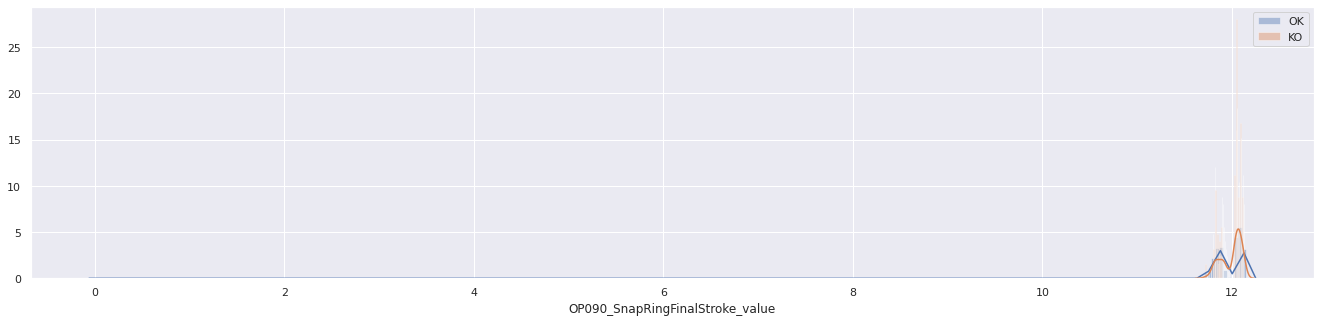

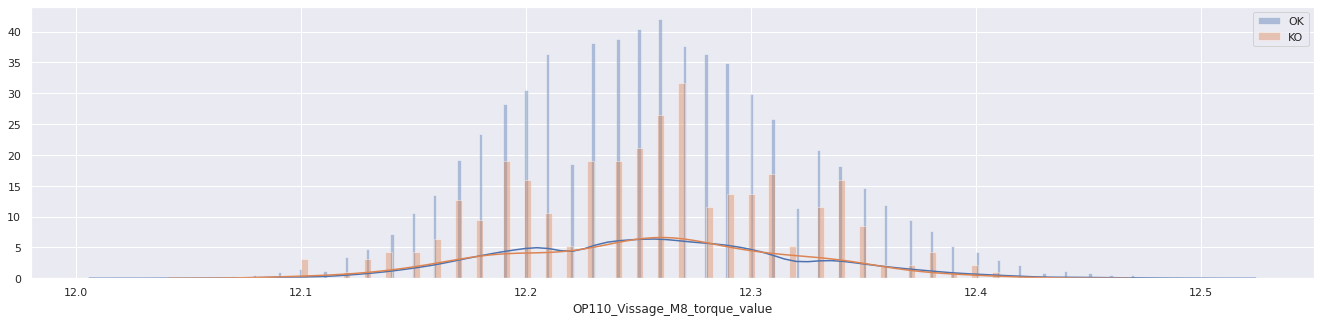

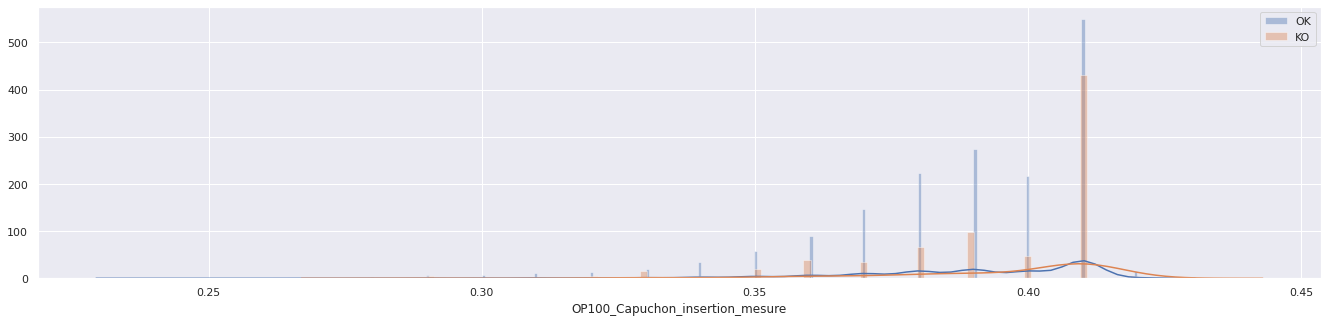

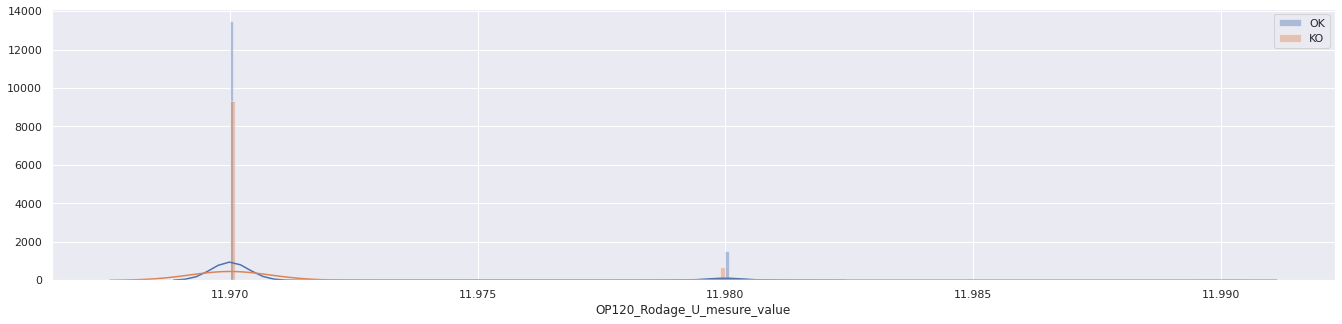

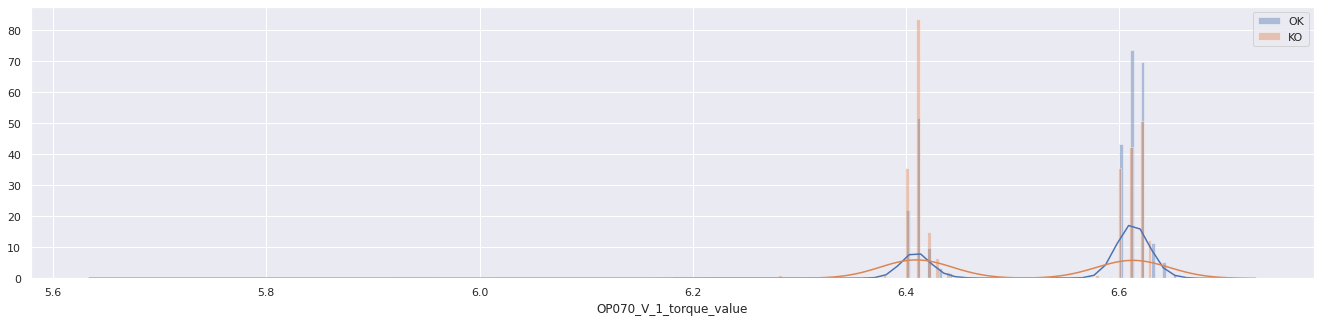

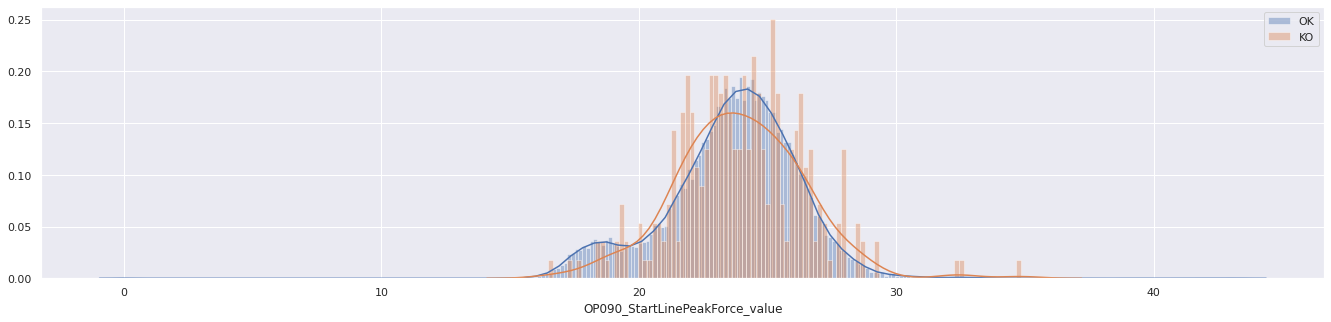

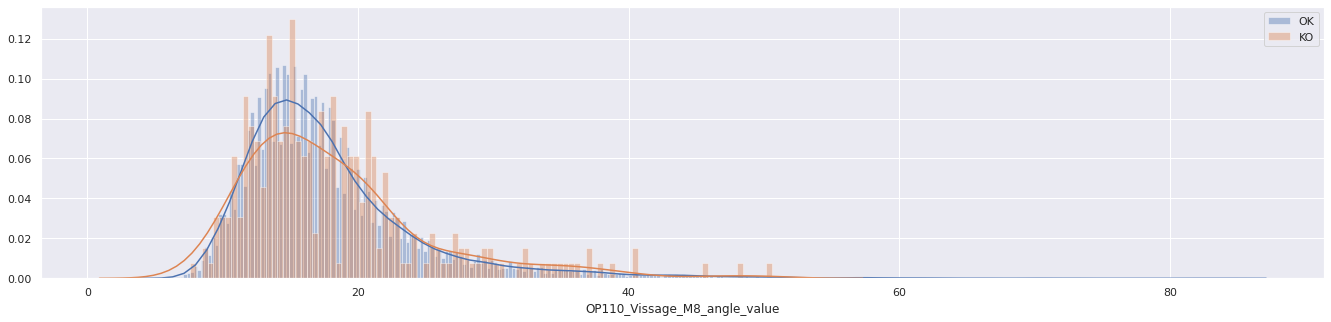

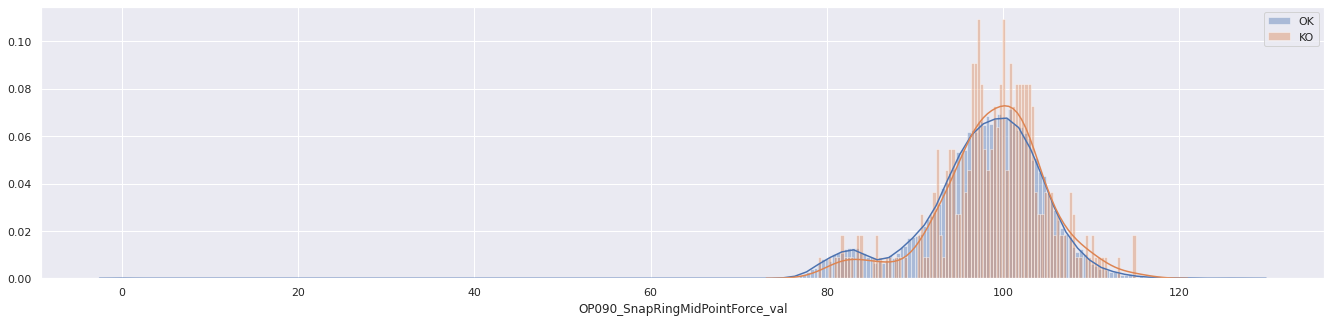

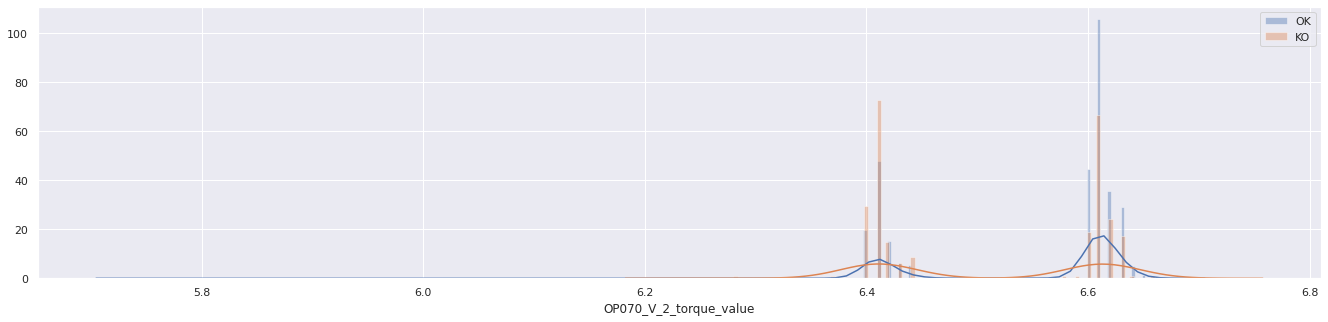

In [13]:
for col in trainset.select_dtypes("float"):
    _ = plt.figure(figsize=(23,5));
    _ = sns.distplot(ok_trainset[col], label="OK", bins=300)
    _ = sns.distplot(ko_trainset[col], label="KO", bins=100)
    _ = plt.legend()

### Variables / Target Relation: Boxplot

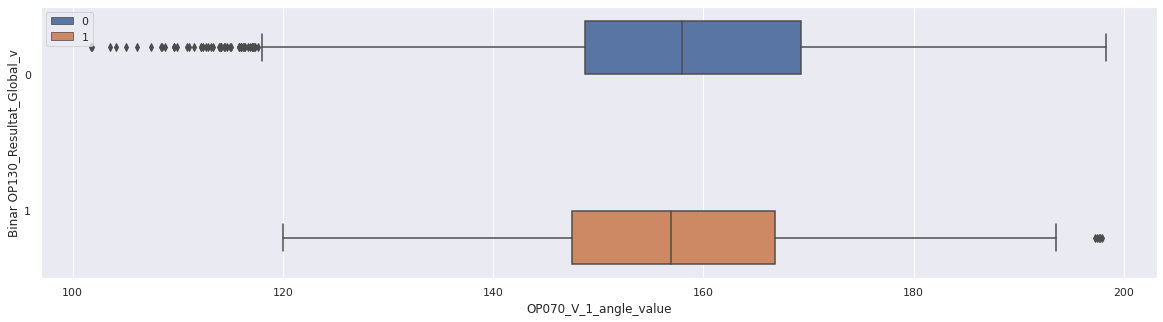

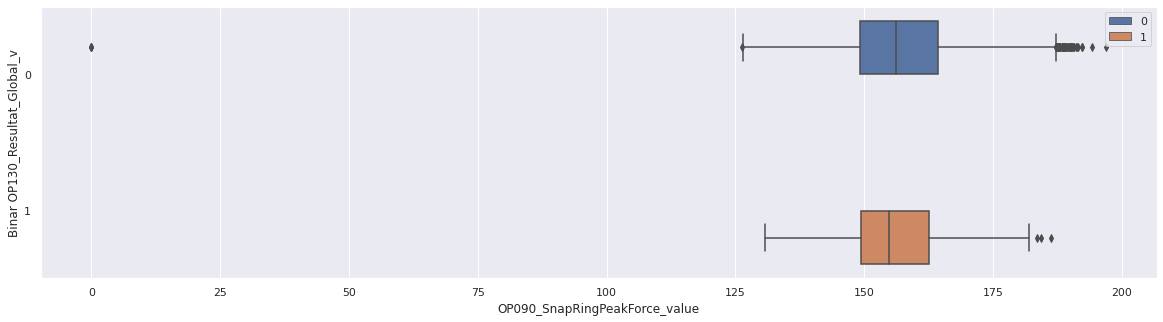

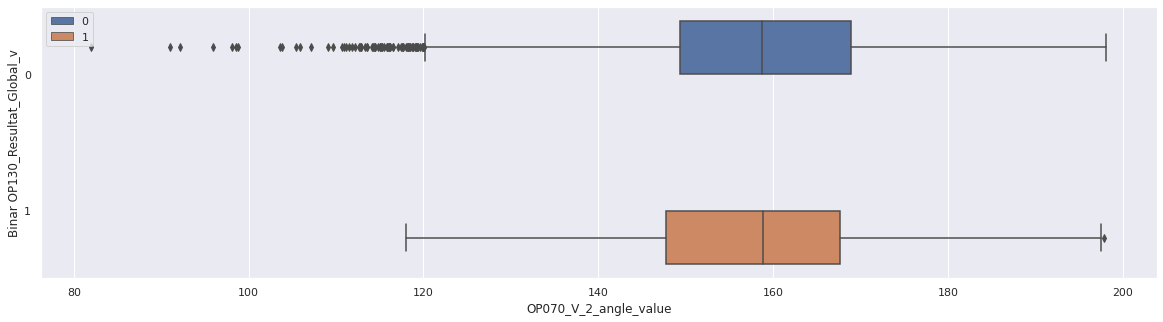

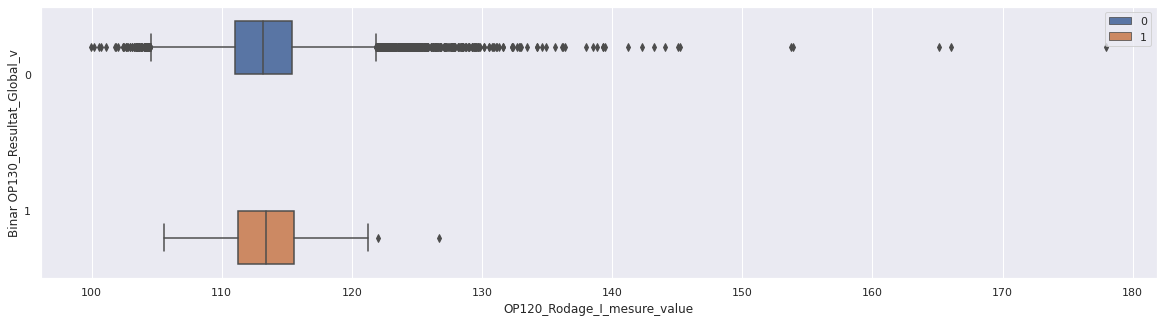

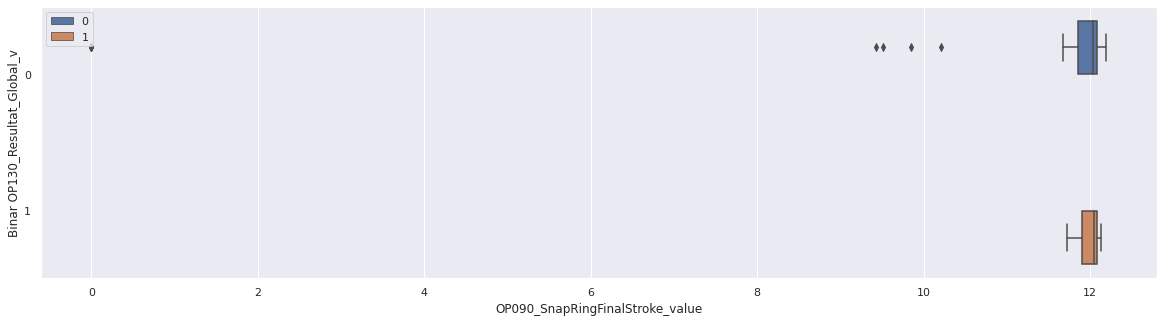

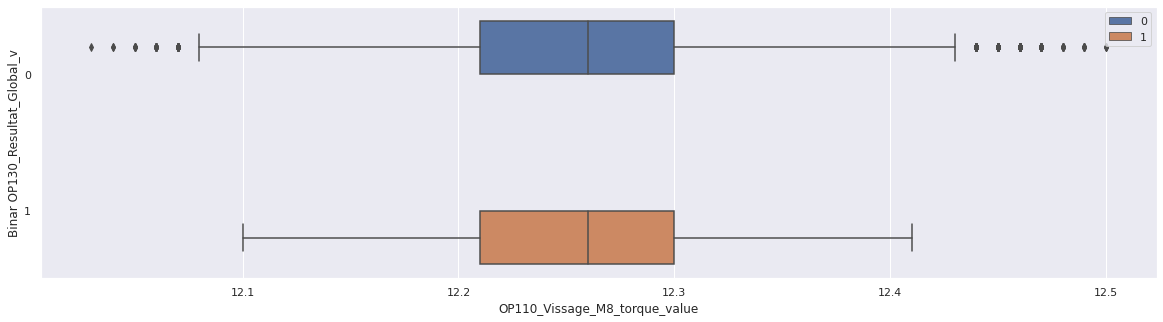

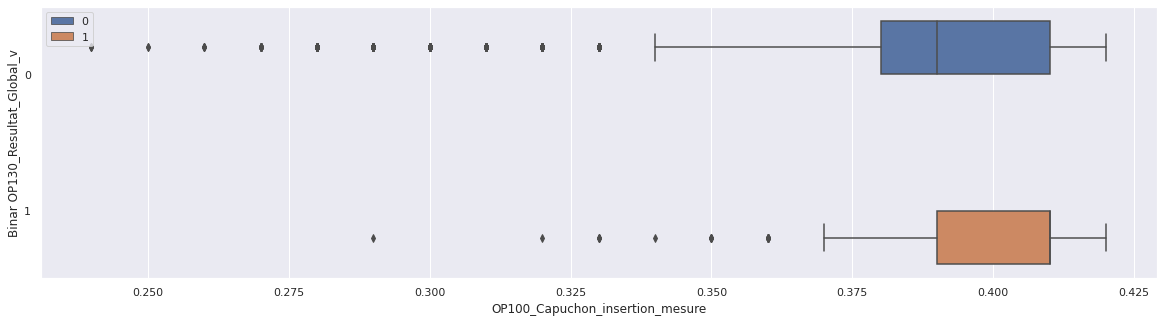

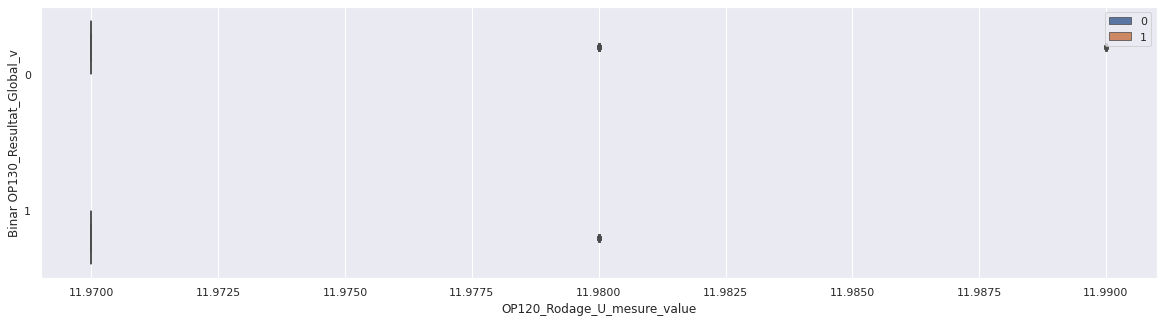

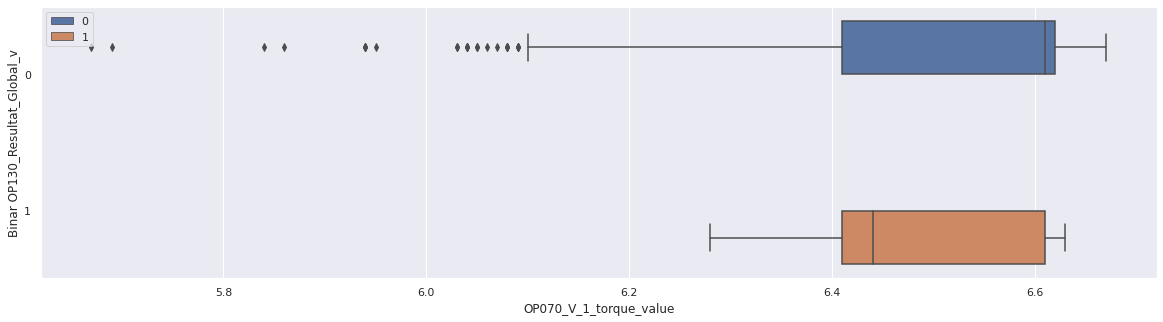

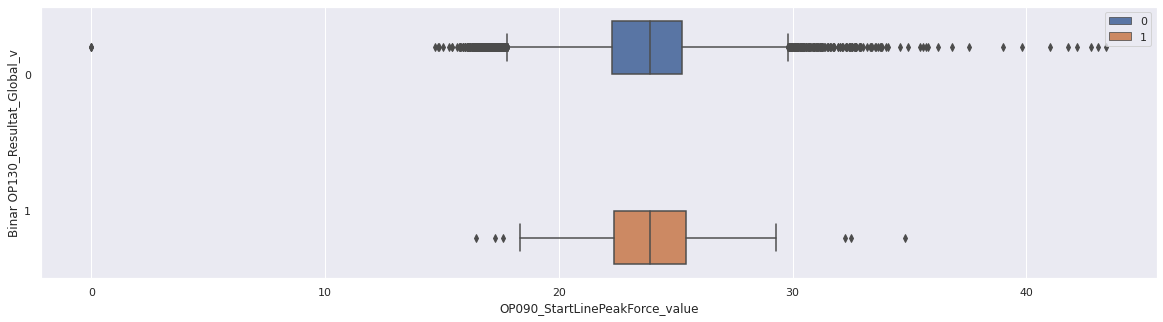

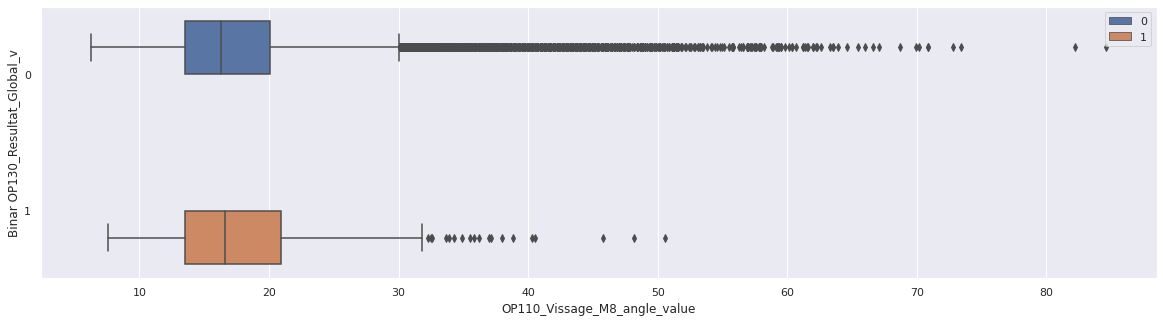

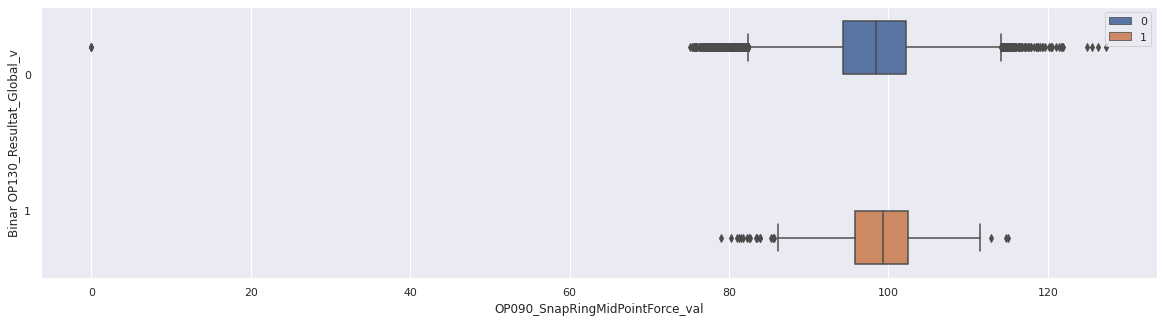

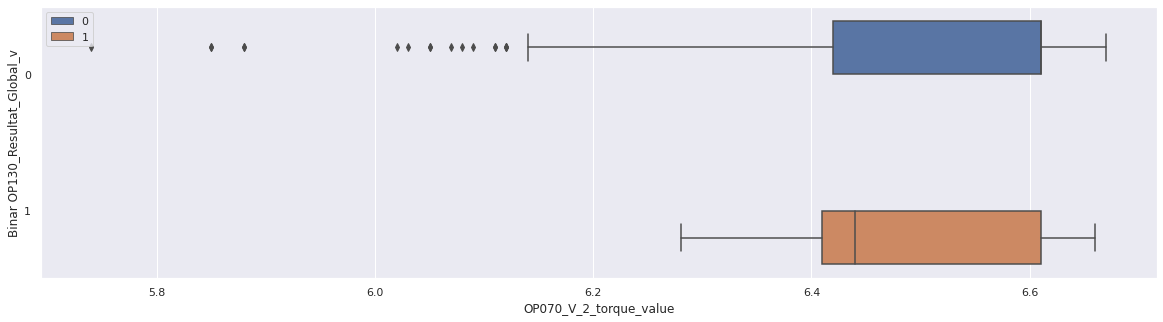

In [65]:
for col in trainset.select_dtypes("float"):
    _ = plt.figure(figsize=(20,5));
    _ = sns.boxplot(x=col, y=target, hue=target, data=trainset, orient="h")
    _ = plt.legend()

### Variables / Variables Relation

In [32]:
#Rebalancing data
trainset = trainset.sample(frac=1, random_state=0) # Lets shuffle the data before creating the subsamples

ko_df = trainset[trainset[target]==1]
ok_df = trainset[trainset[target]==0][:ko_df.shape[0]]  # amount of KO classes ko_df.shape[0] rows.
    
trainset = pd.concat([ok_df,ko_df], axis=0)

In [18]:
trainset["Binar OP130_Resultat_Global_v"].value_counts(normalize=True)

1    0.5
0    0.5
Name: Binar OP130_Resultat_Global_v, dtype: float64

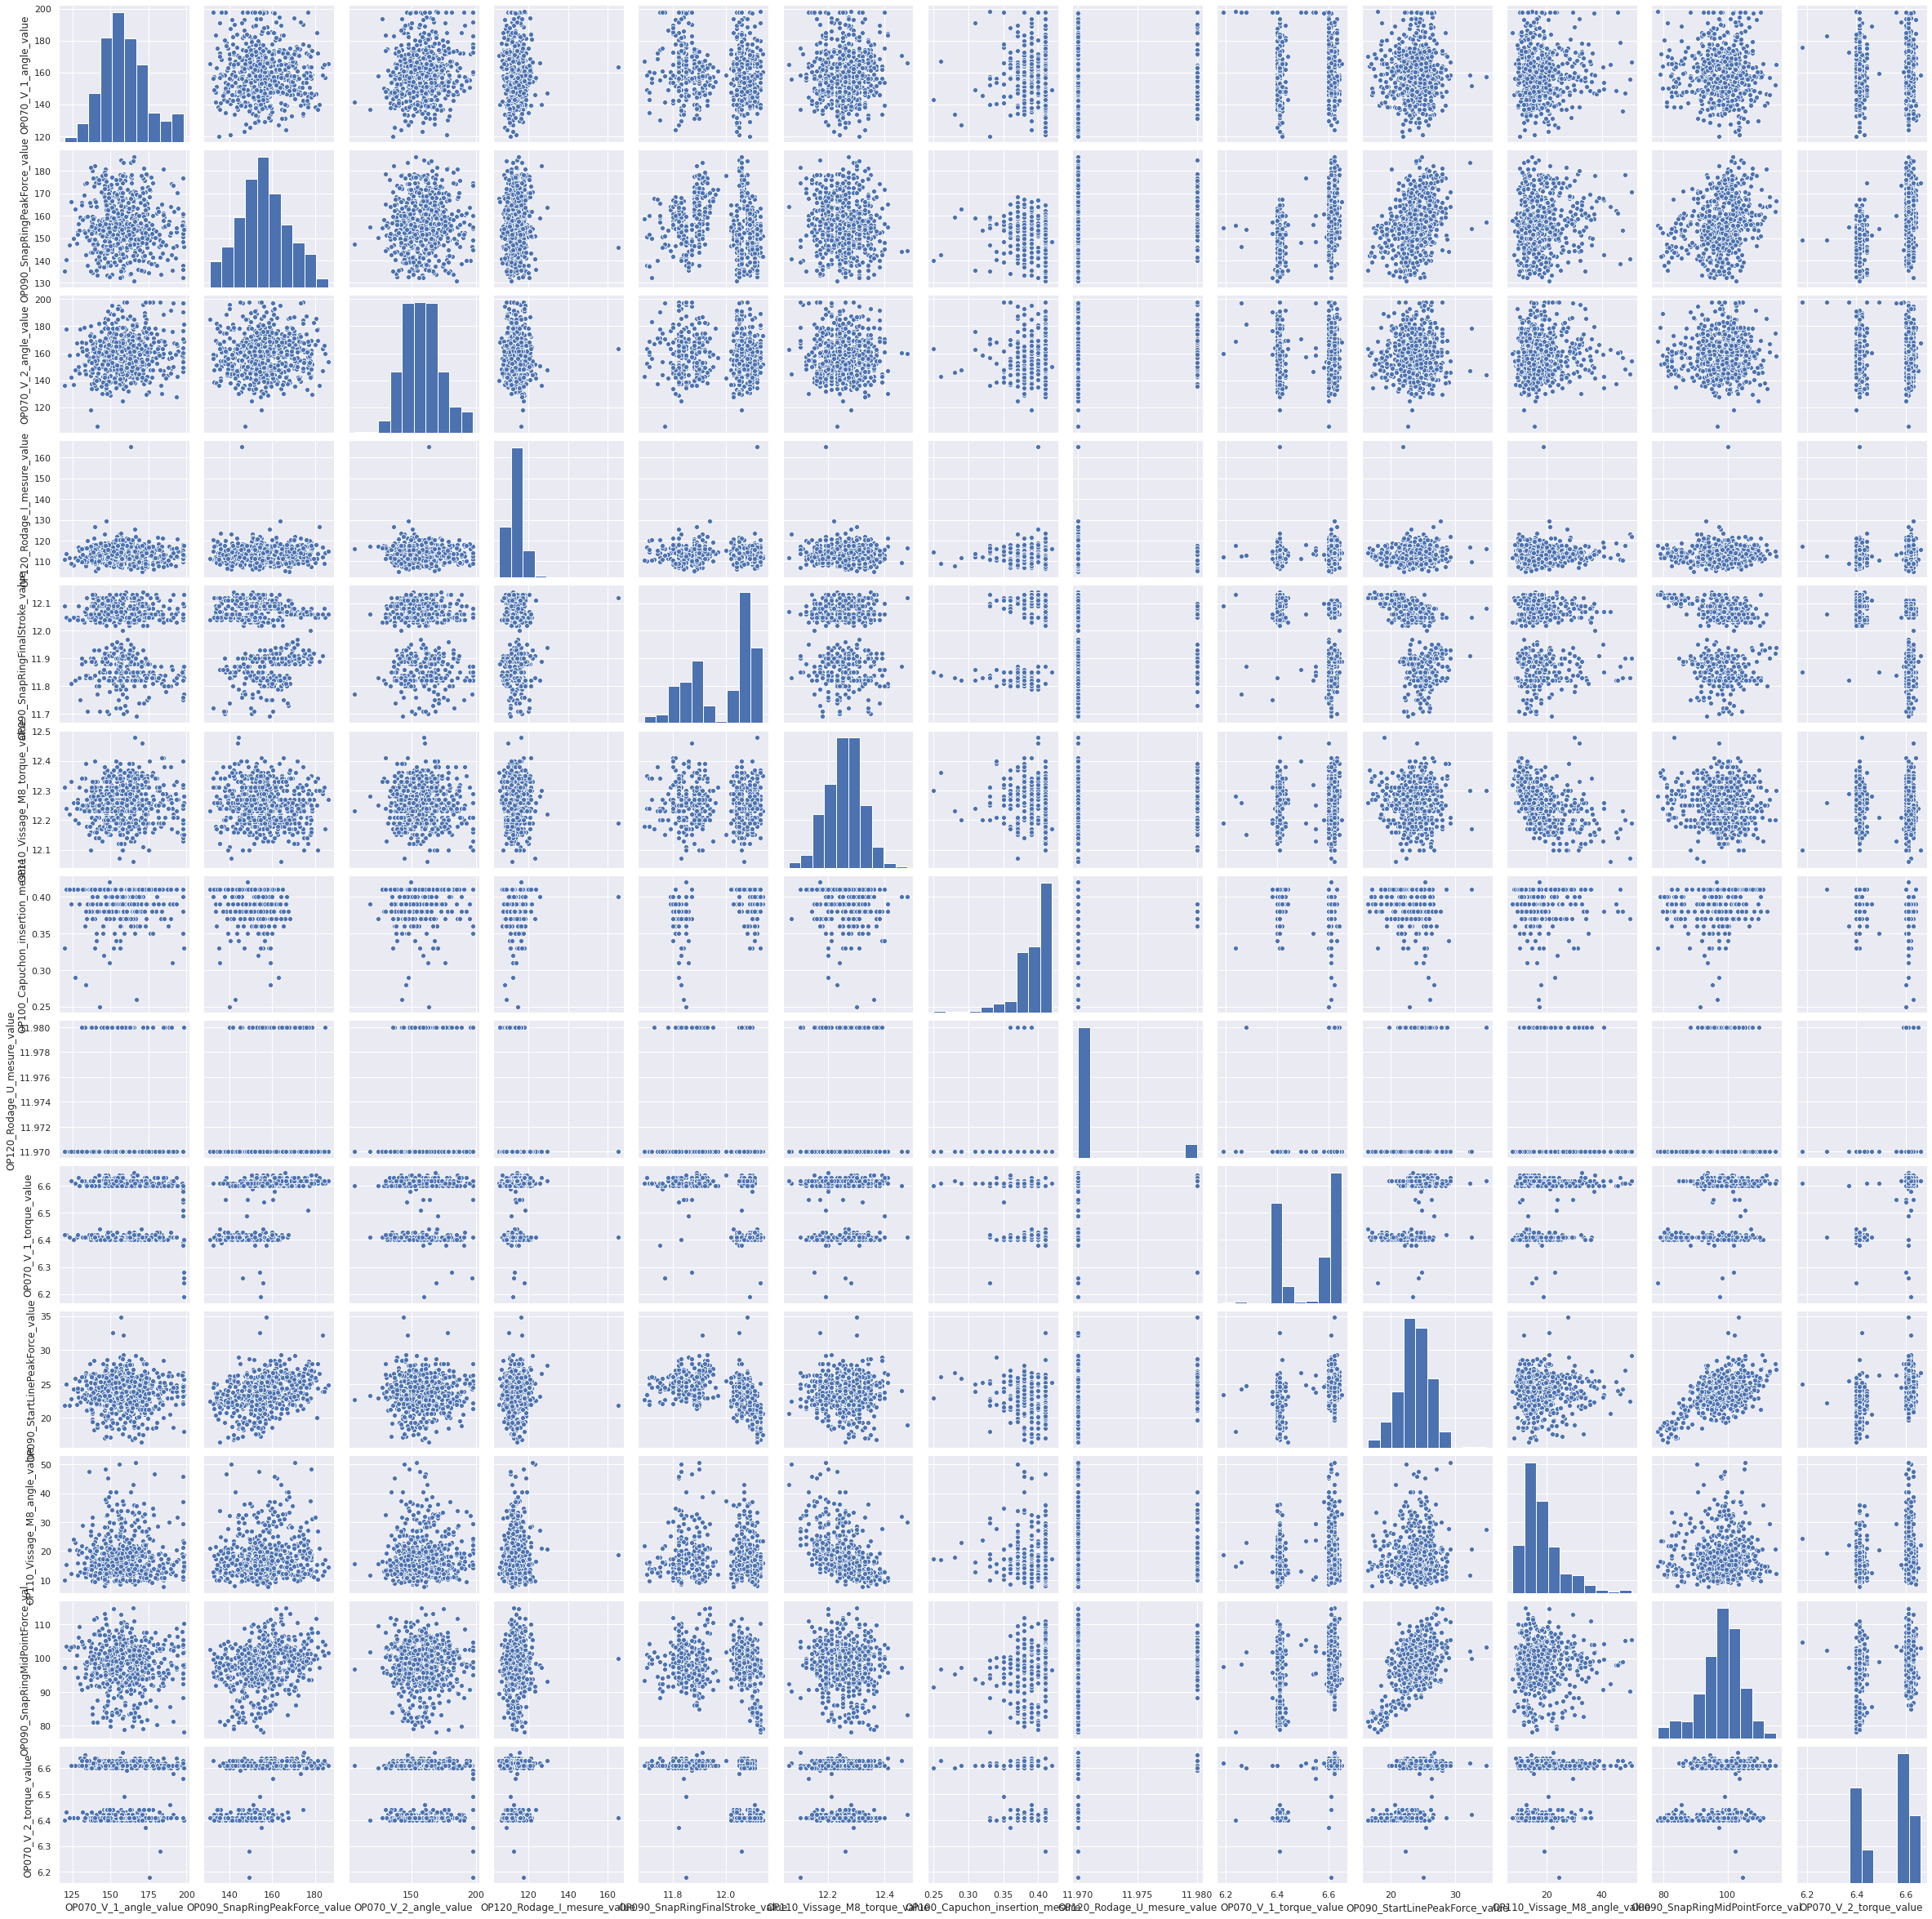

In [24]:
sns.pairplot(trainset.select_dtypes('float'))

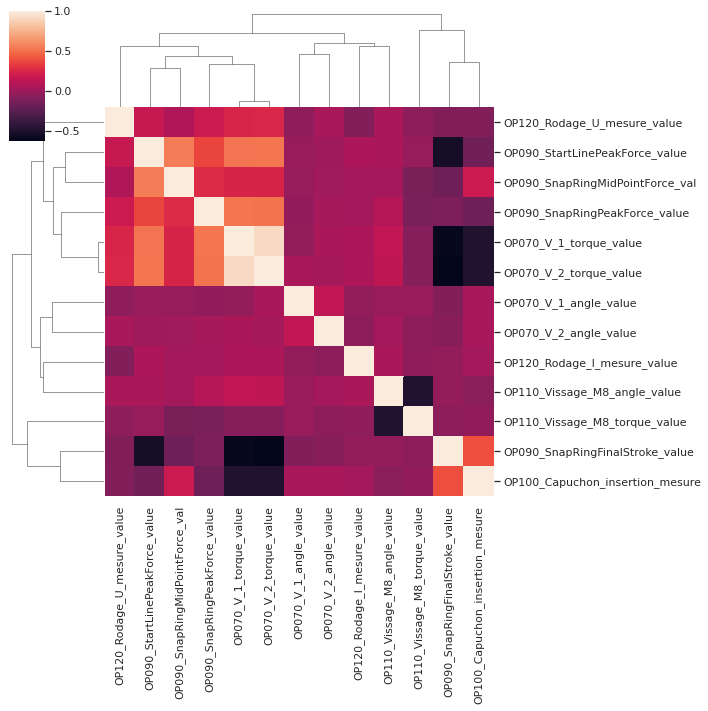

In [25]:
sns.clustermap(trainset.select_dtypes('float').corr())

## Hypothesis Tests : T-test

In [27]:
from scipy.stats import ttest_ind

In [52]:
def t_test(col):
    alpha = 0.02
    stat, p = ttest_ind(ok_df[col].dropna(), ko_df[col].dropna())
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 0

In [53]:
for col in measures:
    print(f'{col :-<50} {t_test(col)}')

OP070_V_1_angle_value----------------------------- H0 Rejetée
OP090_SnapRingPeakForce_value--------------------- 0
OP070_V_2_angle_value----------------------------- 0
OP120_Rodage_I_mesure_value----------------------- 0
OP090_SnapRingFinalStroke_value------------------- H0 Rejetée
OP110_Vissage_M8_torque_value--------------------- 0
OP100_Capuchon_insertion_mesure------------------- H0 Rejetée
OP120_Rodage_U_mesure_value----------------------- 0
OP070_V_1_torque_value---------------------------- H0 Rejetée
OP090_StartLinePeakForce_value-------------------- H0 Rejetée
OP110_Vissage_M8_angle_value---------------------- 0
OP090_SnapRingMidPointForce_val------------------- H0 Rejetée
OP070_V_2_torque_value---------------------------- H0 Rejetée
